In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from hyperopt import hp, fmin, rand
import collections
import statsmodels.api as sm

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv("Sample_Madrid.csv")
df

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,El Viso,Entire home/apt,73,5,5,2019-06-16,0.70,1,3,Madrid
1,Universidad,Private room,30,1,26,2019-09-13,9.63,13,228,Madrid
2,Puerta del Angel,Entire home/apt,100,3,20,2019-09-09,3.64,10,89,Madrid
3,Puerta del Angel,Entire home/apt,65,1,8,2019-09-08,2.89,1,167,Madrid
4,Sol,Entire home/apt,180,2,4,2019-06-30,1.03,1,2,Madrid
...,...,...,...,...,...,...,...,...,...,...
4065,Justicia,Shared room,16,1,156,2019-09-02,4.80,8,73,Madrid
4066,Jerónimos,Entire home/apt,90,3,5,2018-11-28,0.11,2,343,Madrid
4067,Palacio,Entire home/apt,70,1,88,2019-09-01,3.07,1,160,Madrid
4068,Palacio,Entire home/apt,110,1,27,2019-09-02,3.06,4,146,Madrid


In [3]:
df = df.drop(columns=['neighbourhood'])
df = df.drop(columns=['city'])
df = df.drop(columns=['last_review'])


<AxesSubplot:>

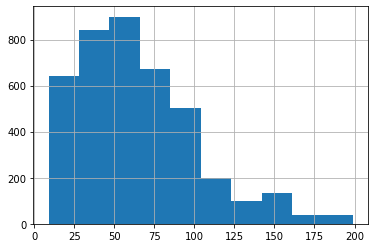

In [4]:
df.price.hist()

<AxesSubplot:>

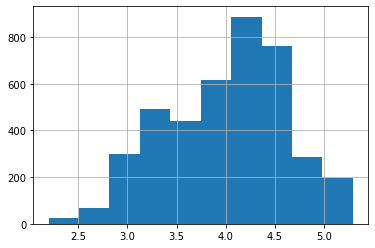

In [5]:
np.log(df.price).hist()

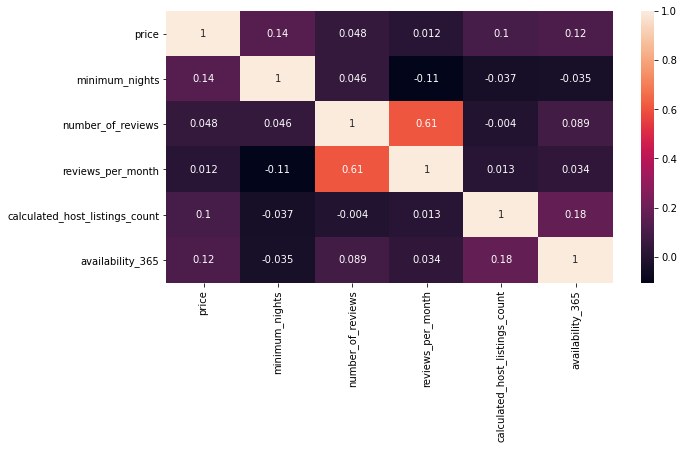

In [6]:
corrmat = df[df._get_numeric_data().columns].corr().round(7)
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corrmat, annot=True)
plt.show()

In [7]:
df.price=np.log(df.price)

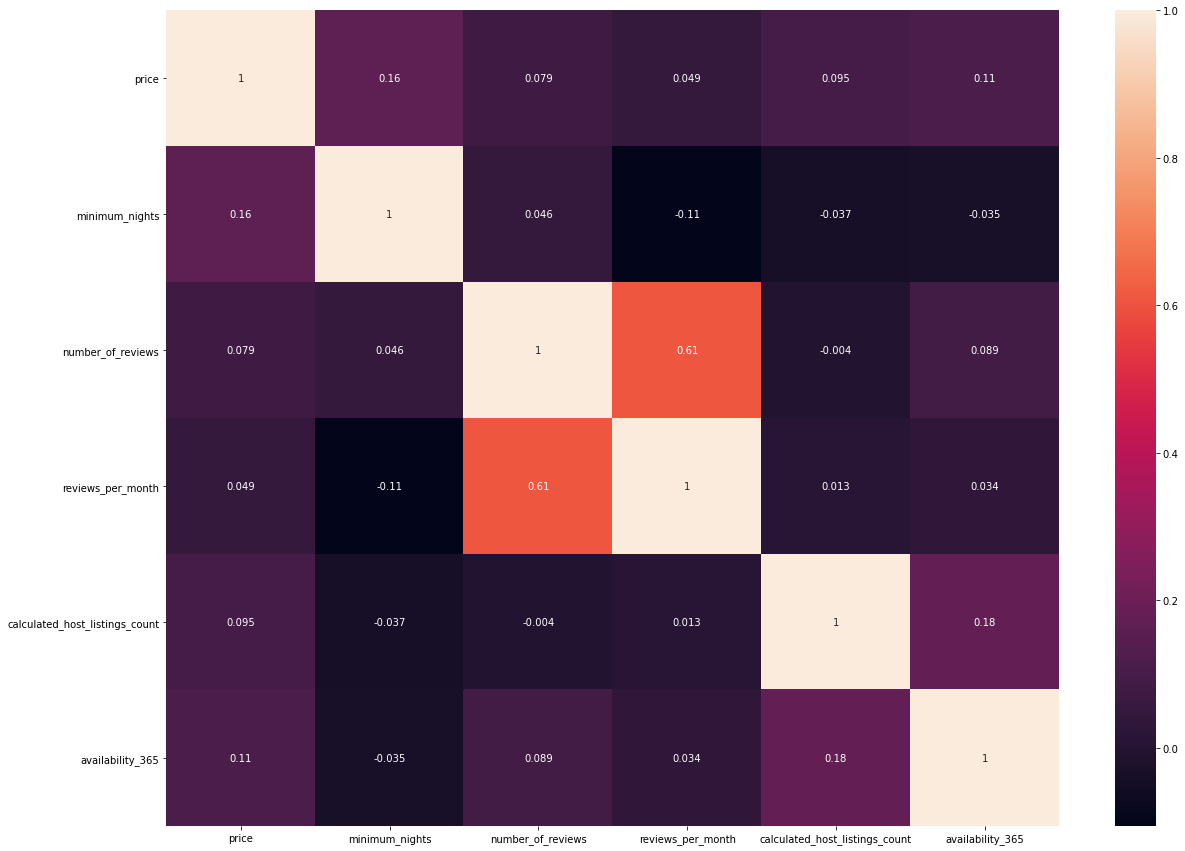

In [8]:
corrmat = df[df._get_numeric_data().columns].corr().round(7)
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(corrmat, annot=True)
plt.show()

In [9]:
def encoding_char(df):
    char_var = list(set(df.columns) - set(df._get_numeric_data().columns))
    for col_names in char_var:
        f = pd.factorize(df[col_names])
        df[col_names] = pd.factorize(df[col_names])[0]
    return(df)

df = encoding_char(df)
df.head()

,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,0,4.290459,5,5,0.70,1,3
1,1,3.401197,1,26,9.63,13,228
2,0,4.605170,3,20,3.64,10,89
3,0,4.174387,1,8,2.89,1,167
4,0,5.192957,2,4,1.03,1,2


In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=0)
X_train = train.drop('price', axis=1)
X_test = test.drop('price', axis=1)
y_train = train.price
y_test = test.price

In [11]:
def metrics(X_train, X_test, y_train, y_test, y_pred, model):
    MSE = [mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train))), mean_squared_error(np.exp(y_test), np.exp(y_pred))]
    RMSE = [np.sqrt(mean_squared_error(np.exp(y_train), np.exp(model.predict(X_train)))),np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))]
    R2 = [model.score(X_train, y_train), model.score(X_test, y_test)]
    results = {'MSE': MSE, 'RMSE': RMSE, 'R2':R2}
    return pd.DataFrame(results, index=['Train', 'Test'])

def visualising(X_train, X_test, y_train, y_test, y_pred, model):
    ### Training set ### 
    plt.scatter(X_train[['reviews_per_month']], np.exp(y_train), color = 'red')
    plt.plot(X_train[['reviews_per_month']], np.exp(model.predict(X_train)), 'bo')
    plt.title('Price vs Reviews per month (Training set) Madrid')
    plt.xlabel('Reviews per month')
    plt.ylabel('Price')
    plt.show()
    
    ### Test set ### 
    plt.scatter(X_test[['reviews_per_month']], np.exp(y_test), color = 'red')
    plt.plot(X_test[['reviews_per_month']], np.exp(y_pred), 'bo')
    plt.title('Price vs Reviews per month (Test set) Madrid')
    plt.xlabel('Reviews per month')
    plt.ylabel('Price')
    plt.show()


In [35]:
mr = LinearRegression().fit(X_train, y_train)
mr.coef_, mr.intercept_

(array([-6.34968860e-01,  1.77361445e-02,  4.94279107e-05, -2.13976917e-02,
         1.45164067e-02,  5.46277339e-04]),
 4.153340417171172)

In [13]:
mr_y_pred = mr.predict(X_test)
metrics(X_train, X_test, y_train, y_test, mr_y_pred, mr).round(2)

,MSE,RMSE,R2
Train,947.77,30.79,0.40
Test,810.61,28.47,0.46


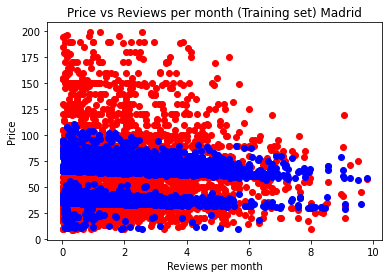

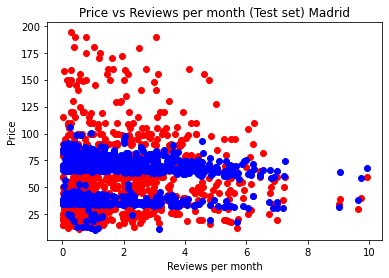

In [14]:
visualising(X_train, X_test, y_train, y_test, mr_y_pred, mr)

In [15]:
X = sm.add_constant(X_train)
mr1 = sm.OLS(y_train, X).fit()
#mr1.pvalues
mr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     367.7
Date:                Sat, 13 Feb 2021   Prob (F-statistic):               0.00
Time:                        20:02:51   Log-Likelihood:                -2126.6
No. Observations:                3256   AIC:                             4267.
Df Residuals:                    3249   BIC:                             4310.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              4.1533      0.027    156.470      0.000       4.101       4.205
room_type                         -0.6350      0.015    -43.482      0.000      -0.664      -0.606
minimum_nights                     0.0177      0.008      2.207      0.027       0.002       0.033
number_of_reviews               4.943e-05      0.000      0.211      0.833      -0.000       0.001
reviews_per_month                 -0.0214      0.006     -3.468      0.001      -0.033      -0.009
calculated_host_listings_count     0.0145      0.002      6.759      0.000       0.010       0.019
availability_365                   0.0005   6.57e-05      8.310      0.000       0.000       0.001
==============================================================================
Omnibus:                      417.451   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1041.564
Skew:                           0.726   Prob(JB):                    6.72e-227
Kurtosis:                       5.360   Cond. No.                         673.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
X_train_opt = X_train.drop(columns=["number_of_reviews"])
X_test_opt = X_test.drop(columns=["number_of_reviews"])
X_train_opt

,room_type,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365
1651,0,3,0.80,5,95
3803,0,2,0.96,1,219
2057,1,1,1.78,1,54
263,0,2,1.00,1,168
1763,0,5,0.05,1,0
...,...,...,...,...,...
835,0,2,4.26,1,130
3264,0,2,1.96,3,222
1653,0,1,0.03,1,0
2607,0,2,2.52,1,30


In [17]:
mr = LinearRegression().fit(X_train_opt, y_train)
mr.coef_, mr.intercept_

(array([-6.35095972e-01,  1.79401857e-02, -2.06063623e-02,  1.45048380e-02,
         5.47641561e-04]),
 4.153179272558213)

In [18]:
mr_y_pred = mr.predict(X_test_opt)
metrics(X_train_opt, X_test_opt, y_train, y_test, mr_y_pred, mr).round(2)

,MSE,RMSE,R2
Train,947.72,30.79,0.40
Test,810.84,28.48,0.46


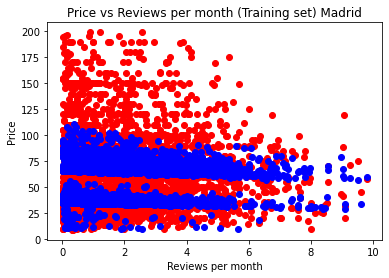

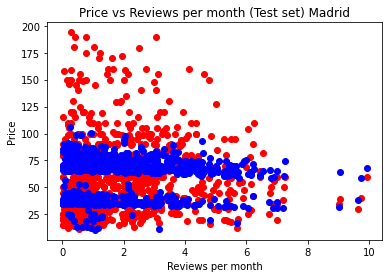

In [19]:
visualising(X_train_opt, X_test_opt, y_train, y_test, mr_y_pred, mr)

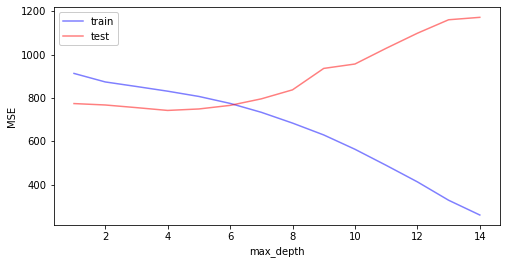

In [20]:
def max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = DecisionTreeRegressor(max_depth = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [21]:
dt = DecisionTreeRegressor(max_depth = 6, random_state=10).fit(X_train, y_train)
dt_y_pred = dt.predict(X_test)
metrics(X_train, X_test, y_train, y_test, dt_y_pred, dt).round(2)

,MSE,RMSE,R2
Train,774.50,27.83,0.58
Test,765.33,27.66,0.55


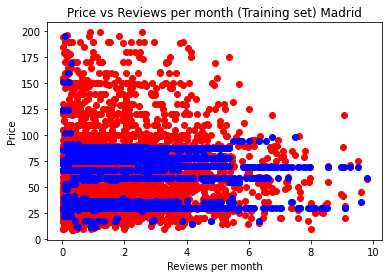

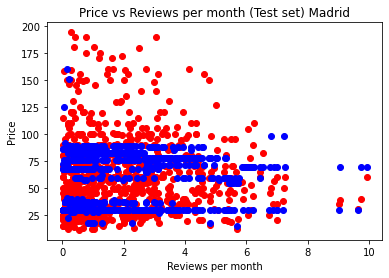

In [22]:
visualising(X_train, X_test, y_train, y_test, dt_y_pred, dt)

Text(0.5, 1.0, 'Decision Tree. Feature Importance. Madrid')

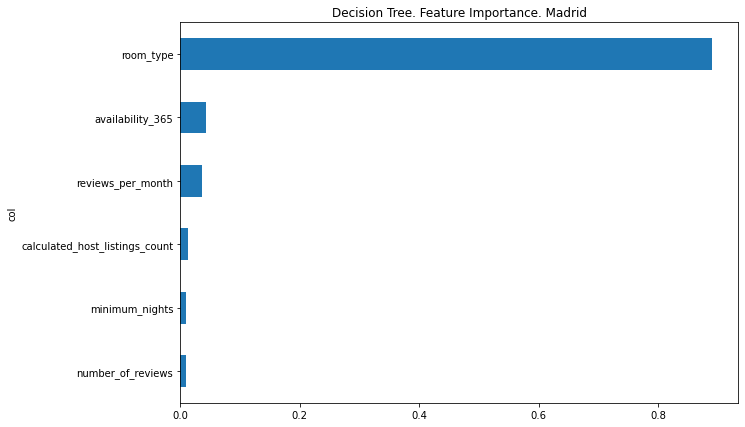

In [23]:
dt_imp = pd.DataFrame({'imp': dt.feature_importances_, 'col': X_train.columns})
dt_imp = dt_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
dt_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Decision Tree. Feature Importance. Madrid')

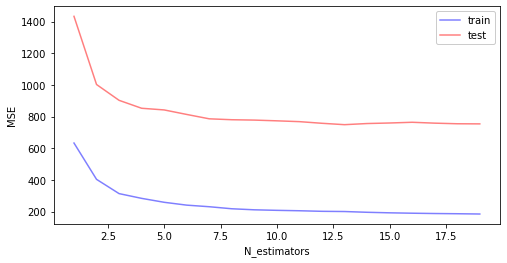

In [24]:
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
rf_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,20)))

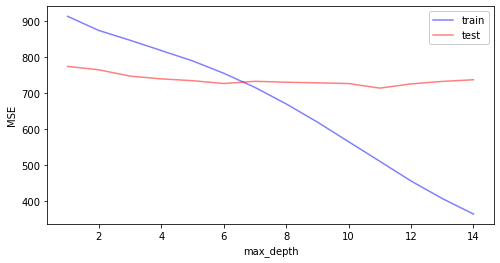

In [25]:
def rf_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=10, max_depth =i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(rf.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(rf.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
rf_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [26]:
rf = RandomForestRegressor(n_estimators = 5, max_depth = 7, random_state = 10).fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
metrics(X_train, X_test, y_train, y_test, rf_y_pred, rf).round(2)

,MSE,RMSE,R2
Train,735.17,27.11,0.61
Test,739.23,27.19,0.57


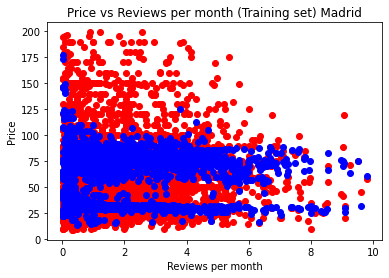

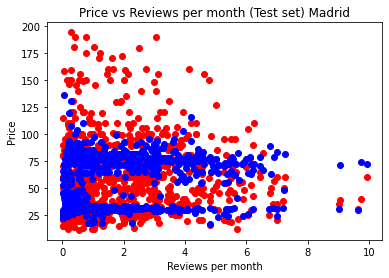

In [27]:
visualising(X_train, X_test, y_train, y_test, rf_y_pred, rf)

Text(0.5, 1.0, 'Random Forest. Feature Importance. Madrid')

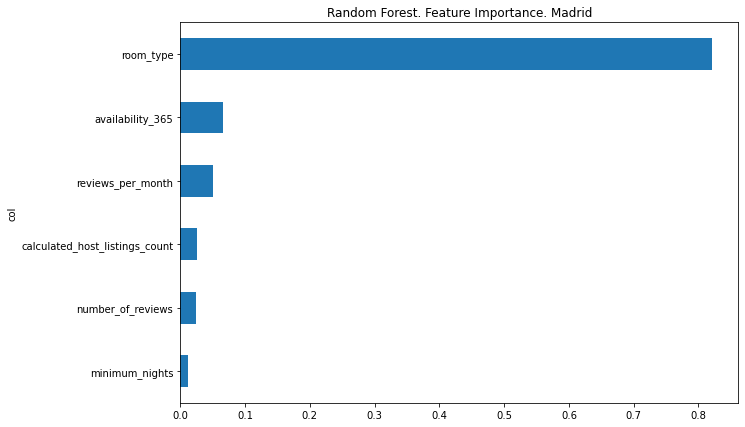

In [28]:
rf_imp = pd.DataFrame({'imp': rf.feature_importances_, 'col': X_train.columns})
rf_imp = rf_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
rf_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Random Forest. Feature Importance. Madrid')

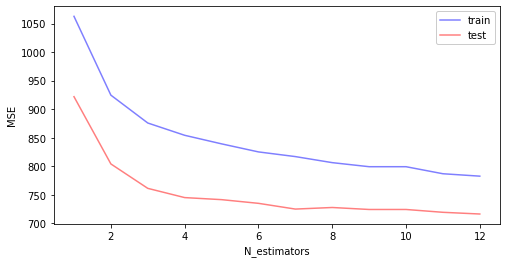

In [29]:
def catboost_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    ax.legend(framealpha=1, frameon=True);

    
catboost_best_n_estimator(X_train, X_test, y_train, y_test, list(range(1,13)))



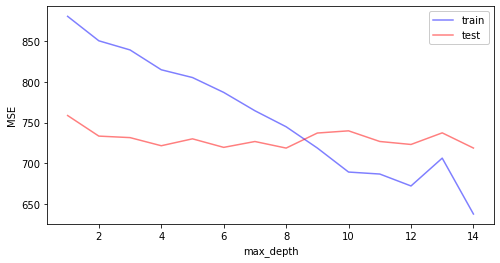

In [30]:
def catboost_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=11, max_depth=i, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
        mse_train.append(mean_squared_error(np.exp(y_train), np.exp(catboost.predict(X_train))))
        mse_test.append(mean_squared_error(np.exp(y_test), np.exp(catboost.predict(X_test))))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

    
catboost_max_depth(X_train, X_test, y_train, y_test, list(range(1,15)))

In [31]:
catboost = CatBoostRegressor(iterations=11, max_depth=8, random_state=10, eval_metric='RMSE', loss_function='RMSE').fit(X_train, y_train,
                                                                                                                 eval_set=(X_test, y_test),
                                                                                                                  logging_level='Silent')
cat_y_pred = catboost.predict(X_test)
metrics(X_train, X_test, y_train, y_test, cat_y_pred, catboost).round(2)

,MSE,RMSE,R2
Train,744.88,27.29,0.61
Test,718.69,26.81,0.58


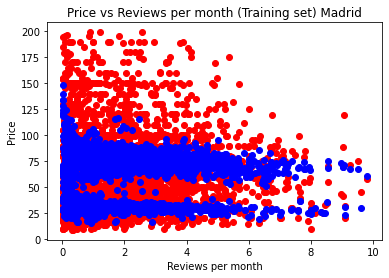

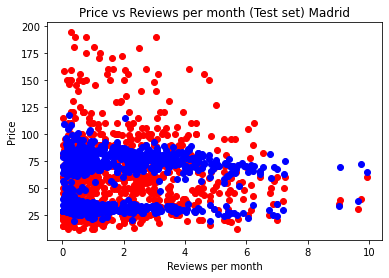

In [32]:
visualising(X_train, X_test, y_train, y_test, cat_y_pred, catboost)

Text(0.5, 1.0, 'Boosting. Feature Importance. Madrid')

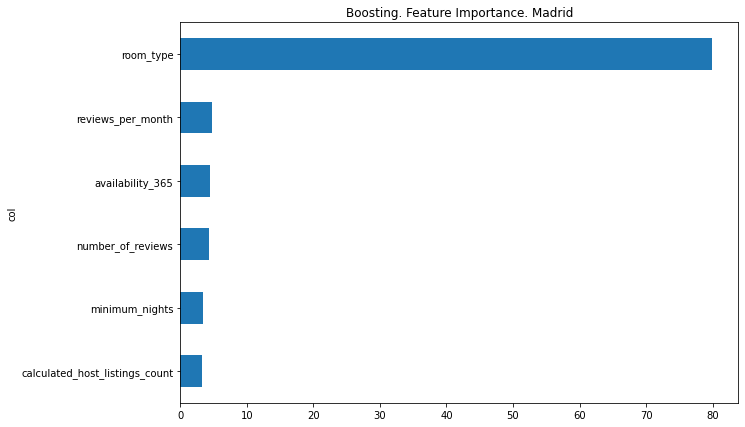

In [33]:
cb_imp = pd.DataFrame({'imp': catboost.get_feature_importance(), 'col': X_train.columns})
cb_imp = cb_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
cb_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance. Madrid')

In [40]:
metric_lr = metrics(X_train, X_test, y_train, y_test, mr_y_pred, mr).round(2)
metric_lr["Type"] = "Linear regression"
metric_lr["city"] = "Madrid"
metric_lr
metric_dt = metrics(X_train, X_test, y_train,y_test, dt_y_pred, dt).round(2).abs()
metric_dt["Type"] = "Decision tree"
metric_dt["city"] = "Madrid"
metric_dt
metric_rf = metrics(X_train, X_test, y_train,y_test,  rf_y_pred, rf).round(2).abs()
metric_rf["Type"] = "Random forest"
metric_rf["city"] = "Madrid"
metric_rf
metric_cb = metrics(X_train, X_test, y_train,y_test, cat_y_pred, catboost).round(2)
metric_cb["Type"] = "Catboost"
metric_cb["city"] = "Madrid"
metric_cb
metric=pd.concat([metric_lr,metric_dt,metric_rf,metric_cb])
metric

,MSE,RMSE,R2,Type,city
Train,947.77,30.79,0.40,Linear regression,Madrid
Test,810.84,28.48,0.46,Linear regression,Madrid
Train,774.50,27.83,0.58,Decision tree,Madrid
Test,765.33,27.66,0.55,Decision tree,Madrid
Train,735.17,27.11,0.61,Random forest,Madrid
Test,739.23,27.19,0.57,Random forest,Madrid
Train,744.88,27.29,0.61,Catboost,Madrid
Test,718.69,26.81,0.58,Catboost,Madrid


In [42]:
metric.to_csv('Metric_Madrid.csv', index=True)